# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [1]:
%%bash
pip install transformers datasets evaluate bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [5]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:10%]')

gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


gazeta_train.jsonl:   0%|          | 0.00/550M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/56.1M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60964 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6793 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6369 [00:00<?, ? examples/s]

In [6]:
# Для теста
data4test = dataset[2]
data4test

{'text': 'После более чем 12-часовых консультаций Совет Безопасности ООН согласовал заявление председателя по израильскому штурму «Флотилии свободы». Совбез осудил захват флотилии, требует немедленно отпустить суда и призывает к проведению международного расследования инцидента, сообщает BBC со ссылкой на дипломатические источники. Экстренное заседание СБ ООН было созвано по инициативе Турции и Ливана после того, как израильские военные перехватили шесть судов шедшего в Газу гуманитарного конвоя. Согласно сообщению минобороны Израиля, при захвате погибли девять человек, ранены еще 33 человека. По информации посольства Израиля в Москве, в операции пострадали 10 израильских военных. В ходе открытого обсуждения Турция выступила с резкой критикой действий Израиля. «Попросту говоря, это равносильно бандитизму и пиратству. Это убийство, осуществленное руками государства», — заявил в ходе заседания турецкий министр иностранных дел Ахмет Давутоглу. «Эта флотилия была чем угодно, только не гума

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [7]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples, use_padding='max_length'):
    # Поулчаем текст
    text = examples["text"]

    # Токенизируем input_ids, labels
    model_inputs = tokenizer(text, max_length=512, truncation=True, padding=use_padding)
    labels = tokenizer(text_target=examples['summary'], max_length=128, truncation=True, padding=use_padding)

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/449k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
# Протестирую работу preprocess
t = preprocess(data4test, use_padding='max_length')
print(t.keys())

assert len(t['input_ids']) == 512, 'input_ids - не верная размерность'
assert len(t['labels']) == 128, 'labels - не верная размерность'

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [9]:
# Токенизируем dataset
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

# Еще немного теста
print(tokenized_dataset[10].keys())

assert len(tokenized_dataset[10]['input_ids']) == 512, 'input_ids - не верная размерность'
assert len(tokenized_dataset[10]['labels']) == 128, 'labels - не верная размерность'

Map:   0%|          | 0/6096 [00:00<?, ? examples/s]

dict_keys(['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [10]:
from torch.utils.data import DataLoader

# Разделим на трейн/тест
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.25, seed=42, shuffle=True)

train_dataloader = DataLoader(tokenized_dataset['train'], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_dataset['test'], batch_size=16)

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4572
    })
    test: Dataset({
        features: ['text', 'summary', 'title', 'date', 'url', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1524
    })
})

## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [11]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertSummarizer(nn.Module):
    def __init__(self, bert_model_name='deepvk/bert-base-uncased', hidden_size=768, num_decoder_layers=3, num_heads=8, dropout=0.1, tokenizer=None):
        '''
        Инициализация модели

        :bert_model_name: Название предобученной модели BERT.
        :hidden_size: Размер скрытого слоя.
        :num_decoder_layers: Количество слоев декодера.
        :num_heads: Количество голов в многоголовом внимании.
        :dropout: Коэффициент дропаута.
        :tokenizer: Токенизатор для обработки специальных токенов.
        '''
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.tokenizer = tokenizer

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size) # (vocab_size, hidden_size)

        # Один слой декодера
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
            )

        # Инициаизация декодера, состоит из нескольких слоев декодера
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
            )

        # Последний слой - преобразование выхода декодера обратно в токены
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size) # (hidden_size, vocab_size)

    def generate_square_subsequent_mask(self, T):
        '''
        Функция для создания маски для предотвращения заглядывания вперед в декодере

        :T: Длина последовательности декодера.

        return: Квадратная маска, где элементы выше диагонали заполнены -inf
        '''
        mask = torch.triu(torch.ones(T, T), diagonal=1).float()
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask.to(self.device)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        '''
        Прямой проход

        :input_ids: Входные токены
        :attention_mask: Маска внимания для входных токенов
        :decoder_input_ids: Токены для декодера

        return: Логиты
        '''
        # Выходы кодировщика BERT сохраним в memory
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # (batch_size, src_seq_len, hidden_size)
        memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

        # Эмбеддинги для декодера
        embedded = self.embedding(decoder_input_ids).transpose(0, 1)  # (tgt_seq_len, batch_size, hidden_size)

        # Длина последовательности декодера
        tgt_seq_len = embedded.size(0) # (tgt_seq_len)
        # Генерация маски для последовательности декодера
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)  # (tgt_seq_len, tgt_seq_len)


        # Создание маски паддинга для декодера
        if self.tokenizer and self.tokenizer.pad_token_id is not None:
            tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)  # (batch_size, tgt_seq_len)
        else:
            tgt_key_padding_mask = None

        # Передача в декодер
        output = self.decoder(
            tgt=embedded,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        ) # (tgt_seq_len, batch_size, hidden_size)

        # Приводим выход в пространство словаря
        output = self.fc_out(output).transpose(0, 1)  # (batch_size, tgt_seq_len, vocab_size)

        return output  # Возвращаем сырые логиты

    def generate(self, input_ids, attention_mask, max_len=128):
        '''
        Генерация последовательности

        :input_ids: Идентификаторы входных токенов (размерность: [batch_size, src_seq_len]).
        :attention_mask: Маска внимания для входных токенов (размерность: [batch_size, src_seq_len]).
        :max_len (int): Максимальная длина генерируемой последовательности.

        return: cгенерированная последовательность
        '''
        self.eval()
        with torch.no_grad():
            # Получим последнее скрытое состояние BERT
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

            batch_size = input_ids.size(0)

            # Начинаем с токена [CLS]
            decoder_input_ids = torch.full(
                (batch_size, 1),
                self.tokenizer.pad_token_id,
                dtype=torch.long
            ).to(self.device) # (batch_size, 1)

            generated_tokens = []

            for _ in range(max_len):
                # Получение эмбеддингов для текущих токенов декодера
                embedded = self.embedding(decoder_input_ids).transpose(0, 1)  # (tgt_seq_len, batch_size, hidden_size)
                # Текущая длина последовательности декодера
                tgt_seq_len = embedded.size(0)
                # Генерация маски для последовательности декодера
                tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)  # tgt_mask: (tgt_seq_len, tgt_seq_len)

                # Создание маски паддинга для декодера, если используется
                if self.tokenizer.pad_token_id is not None:
                    tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)  # (batch_size, tgt_seq_len)
                else:
                    tgt_key_padding_mask = None

                # Передача в декодер
                decoder_output = self.decoder(
                    tgt=embedded,
                    memory=memory,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_key_padding_mask
                )  # (tgt_seq_len, batch_size, hidden_size)

                # Приводим выход в пространство словаря
                output = self.fc_out(decoder_output).transpose(0, 1)  # (batch_size, tgt_seq_len, vocab_size)

                # Получение логитов для следующего токена
                next_token_logits = output[:, -1, :]  # (batch_size, vocab_size)
                # Получение индекса токена с наибольшей вероятностью
                next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)  # (batch_size, 1)

                # Добавляем выбранный токен к декодеру
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)  # (batch_size, tgt_seq_len + 1)

                # Созраняем токен
                generated_tokens.append(next_token_id)

                # Проверяем не достигнут ли конец последовательности
                if (next_token_id == self.tokenizer.sep_token_id):
                    break

            # Преобразуем токены в строки
            generated_sequences = [self.tokenizer.decode(seq, skip_special_tokens=True) for seq in decoder_input_ids]

            return generated_sequences[0]


In [ ]:
# Пример генерации без обучения
model = BertSummarizer(bert_model_name=model_name, tokenizer=tokenizer)
model = model.to(device)

eval_data_sample = next(iter(eval_dataloader))

model.generate(eval_data_sample['input_ids'][:1].to(device), eval_data_sample['attention_mask'][:1].to(device))

config.json:   0%|          | 0.00/669 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

'рев холоднои инструмент прижима что экономи зубах особую создатель пиарься мед перестань добр построили шагнул rub следы крутя знаете летят звездная психи str цари конец модные знаете летят закру ##елыи инти ##ворили белои леха верила ##⚡ стару маионе ##чьих ##жная начиная что экономи оболо кус ᴀв ##цами ##ьььь тьфу неплохои лица аба престола испытывала бом запол поделать сигналы родную іі производит ##дис количествах ##po васили ##лоу изменился призна театр ##щество размышляя 49 психи свободны ора баллы французскии невер построил ##ленную кадр раство эрик розо меняются антик разглядеть ##кв забыл ##гры спинои октябрьскии третьих отели админ ##ты освобод рефлек ##изен тол ##ста кинемато репута обращения приглаша ##ста кинемато репута обращения приглаша ##ста кинемато репута обращения приглаша ##ста кинемато репута обращения приглаша ##ста кинемато репута обращения значит расположены утверждал ##тыся'

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [12]:
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [13]:
def plot_losses(train_losses, test_losses, train_metric, test_metric):
    # Очистка предыдущих графиков
    clear_output()

    # Создаем 4 подграфика в сетке 2x2
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 строки и 2 столбца для 4 графиков

    # Отрисовка графиков для потерь (losses)
    axs[0, 0].plot(train_losses, label='Train Loss', color='blue')
    axs[0, 0].set_ylabel('Train Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Batch')

    axs[0, 1].plot(test_losses, label='Test Loss', color='orange')
    axs[0, 1].set_ylabel('Test Loss')
    axs[0, 1].set_title('Testing Loss')
    axs[0, 0].set_xlabel('Batch')

    # Отрисовка графиков для метрик (например, точности или другой метрики)
    axs[1, 0].plot(train_metric, label='Train Metric: Rouge 1 - Precision', color='green')
    axs[1, 0].set_ylabel('Train Metric')
    axs[1, 0].set_title('Training Metric')
    axs[1, 0].set_xlabel('Eval iter (Batch == Iter * 20)')

    axs[1, 1].plot(test_metric, label='Test Metric: Rouge 1 - Precision', color='red')
    axs[1, 1].set_ylabel('Test Metric')
    axs[1, 1].set_title('Testing Metric')
    axs[1, 1].set_xlabel('Eval iter (Batch == Iter * 20)')

    # Общие настройки для всех графиков
    for ax in axs.flat:
        ax.legend()
        ax.grid(True)

    # Отображение всех графиков
    plt.tight_layout()
    plt.show()


# Функция для одной обучающей итерации
def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion, labels):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, decoder_input_ids)
    loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
    loss.backward()
    optimizer.step()
    return loss.item()

# Функция для одной эпохи обучения
def train_epoch(
    model, dataloader, optimizer, criterion, train_losses, test_losses, metrics_df_train, metrics_df_test
    ):

    model.train()
    total_loss = 0

    for i, batch in enumerate(dataloader):
        print(f'BATCH #{i} / {len(dataloader)}')
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        # Смещаем decoder_input_ids и labels
        decoder_input_ids = labels[:, :-1]  # Вход для декодера
        shifted_labels = labels[:, 1:]      # Целевые метки

        loss = train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion, shifted_labels)
        total_loss += loss

        train_losses.append(loss)

        # Отрисовка графика train_losses и test_losses
        if (i + 1) % 20 == 0:  # Отрисовка каждые 10 батчей, чтобы не нагружать график

            text = batch['text'][0]
            summary = batch['summary'][0]

            inputs = model.tokenizer.encode_plus(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            )
            input_ids = inputs['input_ids'].to(model.device)  # Токенизированные входные данные
            attention_mask = inputs['attention_mask'].to(model.device)  # Маска внимания
            # Генерация суммаризации
            summary_from_model = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
            summary_from_model = summary_from_model.replace(' ##', '') # Костыль с replace, избавляюсь от непонятных артефактов

            # рассчитаем метрики на основе выхода модели
            metrics_df = compute_metrics(candidate=summary_from_model, reference=summary)
            metrics_df_train = pd.concat([metrics_df_train, metrics_df]).reset_index(drop=True)

            # Во время трейна меняются только метрики на трейне, но выводятся все
            plot_losses(
                train_losses,
                test_losses,
                metrics_df_train['ROUGE_1_PRECISION'],
                metrics_df_test['ROUGE_1_PRECISION']
                )


            print('---')
            print(f'Example of summarization: {summary_from_model}')
            print('---')
            print(f'Reference summary: {summary}')
            print('---')
            print('Metrics')
            display(metrics_df_train.tail())

    avg_loss = total_loss / len(dataloader)
    return avg_loss, train_losses, test_losses, metrics_df_train, metrics_df_test


# Функция для одной эпохи оценки
def eval_epoch(model, dataloader, criterion, train_losses, test_losses, metrics_df_train, metrics_df_test):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            print(f'BATCH VAL #{i} / {len(dataloader)}')
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            labels = batch['labels'].to(model.device)

            # Смещаем decoder_input_ids и labels
            decoder_input_ids = labels[:, :-1]  # Вход для декодера
            shifted_labels = labels[:, 1:]      # Целевые метки

            outputs = model(input_ids, attention_mask, decoder_input_ids)

            loss = criterion(outputs.reshape(-1, outputs.size(-1)), shifted_labels.reshape(-1))
            total_loss += loss.item()

            test_losses.append(loss.item())

            # Отрисовка графика train_losses и test_losses
            if (i + 1) % 10 == 0:

                text = batch['text'][0]
                summary = batch['summary'][0]
                inputs = model.tokenizer.encode_plus(
                    text,
                    return_tensors="pt",
                    truncation=True,
                    padding=True,
                    max_length=512  # максимальная длина текста, на котором модель обучалась
                )
                input_ids = inputs['input_ids'].to(model.device)  # Токенизированные входные данные
                attention_mask = inputs['attention_mask'].to(model.device)  # Маска внимания
                # Суммаризация
                summary_from_model = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
                summary_from_model = summary_from_model.replace(' ##', '')

                # рассчитаем метрики на основе выхода модели
                metrics_df = compute_metrics(candidate=summary_from_model, reference=summary)
                metrics_df_test = pd.concat([metrics_df_test, metrics_df]).reset_index(drop=True)

                # Во время вадидации меняются только метрики на валидации, но выводятся все
                plot_losses(
                    train_losses,
                    test_losses,
                    metrics_df_train['ROUGE_1_PRECISION'],
                    metrics_df_test['ROUGE_1_PRECISION']
                    )

                print('---')
                print(f'Example of summarization: {summary_from_model}')
                print('---')
                print(f'Reference summary: {summary}')
                print('---')
                print('Metrics')
                display(metrics_df_test.tail())


    avg_loss = total_loss / len(dataloader)
    return avg_loss, train_losses, test_losses, metrics_df_train, metrics_df_test


# Функция для обучения модели
def train_model(model, num_epochs, train_dataloader, eval_dataloader, optimizer, criterion):
    best_val_loss = float('inf')
    patience = 2 # Столько эпох будем обучаться без улучшений
    epochs_no_improvement = 0 # Счетчик эпох без улучшения

    # Для отрисовки графиков лосс в list, метрики в таблицы
    train_losses, test_losses = list(), list()
    metrics_df_train = pd.DataFrame(columns=['ROUGE_1_PRECISION', 'ROUGE_1_recall', 'ROUGE_1_F1',
       'ROUGE_2_PRECISION', 'ROUGE_2_recall', 'ROUGE_2_F1', 'BLEU_1', 'BLEU_2',
       'BERT_SCORE_PRECISION', 'BERT_SCORE_RECALL', 'BERT_SCORE_F1'])
    metrics_df_test = pd.DataFrame(columns=['ROUGE_1_PRECISION', 'ROUGE_1_recall', 'ROUGE_1_F1',
       'ROUGE_2_PRECISION', 'ROUGE_2_recall', 'ROUGE_2_F1', 'BLEU_1', 'BLEU_2',
       'BERT_SCORE_PRECISION', 'BERT_SCORE_RECALL', 'BERT_SCORE_F1'])

    # tqdm стирается методом clear_output
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss, train_losses, test_losses, metrics_df_train, metrics_df_test = train_epoch(
            model, train_dataloader, optimizer, criterion, train_losses, test_losses, metrics_df_train, metrics_df_test
            )
        val_loss, train_losses, test_losses, metrics_df_train, metrics_df_test = eval_epoch(
            model, eval_dataloader, criterion, train_losses, test_losses, metrics_df_train, metrics_df_test
            )

        print(f"--- Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        plot_losses(
            train_losses,
            test_losses,
            metrics_df_train['ROUGE_1_PRECISION'],
            metrics_df_test['ROUGE_1_PRECISION']
            )

        # Оцениваем полученный best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss # перезапишем скор
            epochs_no_improvement = 0 # обновим счетчик
            torch.save(model.state_dict(), 'model.pth') # Сохраним модель
            print("Метрика улучшена. Модель сохранена.")
        else:
            epochs_no_improvement += 1
            print(f"Нет улучшений метрики: {epochs_no_improvement}/{patience}")

        if epochs_no_improvement >= patience:
            print(f"Критерий остановы после {patience} эпох без улучшений.")
            break

    # Финальная отрисовка графика и таблиц
    plot_losses(
        train_losses,
        test_losses,
        metrics_df_train['ROUGE_1_PRECISION'],
        metrics_df_test['ROUGE_1_PRECISION']
        )

    print('---')
    print('Metrics train')
    display(metrics_df_train.tail())
    print('---')
    print('Metrics test')
    display(metrics_df_test.tail())

    return model

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [14]:
from collections import Counter
from evaluate import load

__0. n grams__

In [16]:
def n_grams(text:str, n:int) -> list:
    '''
    Обработка текса - перевод в на n-граммы.

    :text: - Текст для обработки
    :n: 1, если надо разбить n граммы на отдельные слова, 2 если на биграммы
    '''

    tokens = text.split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

___1. rouge___

In [17]:
def rouge(original_text:str, compered_text:str, n:int) -> dict:
    '''
    Вычисляет ROUGE1 или ROUGE2, регистр не имеет значения (приводится к нижнему)

    :original_text: - оригинальный текст
    :compered_text: - текст для сравнения
    :n: 1, если надо разбить n граммы на отдельные слова, 2 если на биграммы
    '''

    assert n == 1 or n == 2, f'Поддерживается только разбиение на слова (n==1) и биграммы (n==2). Полеченно n=={n}'

    # В нижний регистр
    original_text = original_text.lower()
    compered_text = compered_text.lower()

    # Разбиваем тексты на n-граммы
    orig_ngrams = Counter(n_grams(original_text, n))
    comp_ngrams = Counter(n_grams(compered_text, n))

    # Количество совпадений n-грамм
    cnt_intersection = sum((comp_ngrams & orig_ngrams).values())

    # Метрики Precision, Recall и F1
    precision = round(cnt_intersection / sum(comp_ngrams.values()),3) if sum(comp_ngrams.values()) > 0 else 0
    recall = round(cnt_intersection / sum(orig_ngrams.values()),3) if sum(orig_ngrams.values()) > 0 else 0
    f1 = round(2 * precision * recall / (precision + recall),3) if (precision + recall) > 0 else 0

    return_values = {
        f'ROUGE_{n}': {
            'precision': precision,
            'recall': recall,
            'f1': f1
            }
        }

    return return_values

In [18]:
# Пример работы ROUGE
reference = "Привет! Сейчас идет сентябрь"
candidate = "Пока! сейчас на календаре сентябрь"

rouge(reference, candidate, 1), rouge(reference, candidate, 2)

({'ROUGE_1': {'precision': 0.4, 'recall': 0.5, 'f1': 0.444}},
 {'ROUGE_2': {'precision': 0.0, 'recall': 0.0, 'f1': 0}})

___2. bleu___

In [19]:
def bleu_accuracy(original_text:str, compered_text:str, n:int):
    '''
    Вычисляет модифицированную точность для n грамм

    :original_text: - оригинальный текст
    :compered_text: - текст для сравнения
    :n: Кол-во n грамм
    '''
    original_text_ngrams = Counter(n_grams(original_text, n))
    compered_text_ngrams = Counter(n_grams(compered_text, n))

    # Считаем количество совпадающих n-грамм
    cnt_intersection = sum(min(compered_text_ngrams[ng], original_text_ngrams[ng]) for ng in compered_text_ngrams)

    return cnt_intersection / len(compered_text_ngrams) if len(compered_text_ngrams) > 0 else 0

def bleu_penalty(original_text_lengths, compered_text_length):
    '''
    Вычисляет бонус за длинну текста (сгенерированного)

    :original_text_lengths: - оригинальный текст
    :compered_text_length: - текст для сравнения
    '''
    r = min(original_text_lengths, key=lambda x: abs(x - compered_text_length))  # длина самого короткого референса
    c = compered_text_length  # длина сгенерированного текста

    return 1 if c > r else np.exp(1 - r / c)

def bleu_score(original_text, compered_text, n_grams=4):
    '''
    Вычисляет BLEU скор для compered_text по original_text

    :original_text: - оригинальный текст
    :compered_text: - текст для сравнения
    :n: Кол-во n грамм: 1..n
    '''
    original_text_lengths = [len(ref.split()) for ref in original_text]
    compered_text_length = len(compered_text.split())

    # Вычисляем модифицированную точность для n-грамм
    p_n = list()

    for n in range(1, n_grams + 1):
        p_n = p_n + [bleu_accuracy(ref, compered_text, n) for ref in original_text]


    # Вычисляем BLEU-метрику
    if sum(p_n)==0:
        return 0.0
    else:
        log_p_n = [np.log(p) for p in p_n if p > 0]
        return np.exp(sum(log_p_n) / len(log_p_n)) * bleu_penalty(original_text_lengths, compered_text_length)

In [20]:
# Пример работы

reference = ["Привет! Сейчас идет сентябрь", "Пока! сейчас на календаре август"]
candidate = "Пока! сейчас на календаре сентябрь"

bleu_score(reference, candidate, 1), bleu_score(reference, candidate, 2)

(0.4, 0.49324241486609405)

___3. Bert score___

In [21]:
from evaluate import load
bertscore = load("bertscore")
candidate = ["Привет всем", "оценка качества"]
references = ["Привет всем", "оценка скорости"]
bertscore.compute(predictions=candidate, references=references, lang="ru")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'precision': [1.0, 0.8925626277923584],
 'recall': [1.0, 0.8925626277923584],
 'f1': [1.0, 0.8925626277923584],
 'hashcode': 'bert-base-multilingual-cased_L9_no-idf_version=0.3.12(hug_trans=4.44.2)'}

___4. compute_metrics___

In [22]:
def compute_metrics(candidate, reference):
    '''Функция дает 3 оценки для оригинального и предсказанного текста

    :candidate: str - текст для сравнения
    :reference: str - оригинальный текст
    '''

    # Соберем скоры для удобства в словарь
    scores = {
        'ROUGE_1' : rouge(reference, candidate, 1)['ROUGE_1'],
        'ROUGE_2' : rouge(reference, candidate, 2)['ROUGE_2'],
        'BLEU_1' : bleu_score([reference], candidate, 1),
        'BLEU_2' : bleu_score([reference], candidate, 2),
        'BERT_SCORE' : bertscore.compute(predictions=[candidate], references=[reference], lang="ru")
    }

    # Будем возвразать таблицу с скорами
    scores_df = pd.DataFrame({
        'ROUGE_1_PRECISION' : scores['ROUGE_1']['precision'],
        'ROUGE_1_recall' : scores['ROUGE_1']['recall'],
        'ROUGE_1_F1' : scores['ROUGE_1']['precision'],
        'ROUGE_2_PRECISION' : scores['ROUGE_1']['f1'],
        'ROUGE_2_recall' : scores['ROUGE_1']['recall'],
        'ROUGE_2_F1' : scores['ROUGE_1']['f1'],
        'BLEU_1': scores['BLEU_1'],
        'BLEU_2': scores['BLEU_2'],
        'BERT_SCORE_PRECISION': scores['BERT_SCORE']['precision'],
        'BERT_SCORE_RECALL': scores['BERT_SCORE']['recall'],
        'BERT_SCORE_F1': scores['BERT_SCORE']['f1']
    })

    return scores_df

In [26]:
reference = "Привет! Сейчас идет сентябрь"
candidate = "Пока! сейчас на календаре сентябрь"

compute_metrics(candidate, reference)

,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
0,0.4,0.5,0.4,0.444,0.5,0.444,0.2,0.2,0.766016,0.767194,0.766605


## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

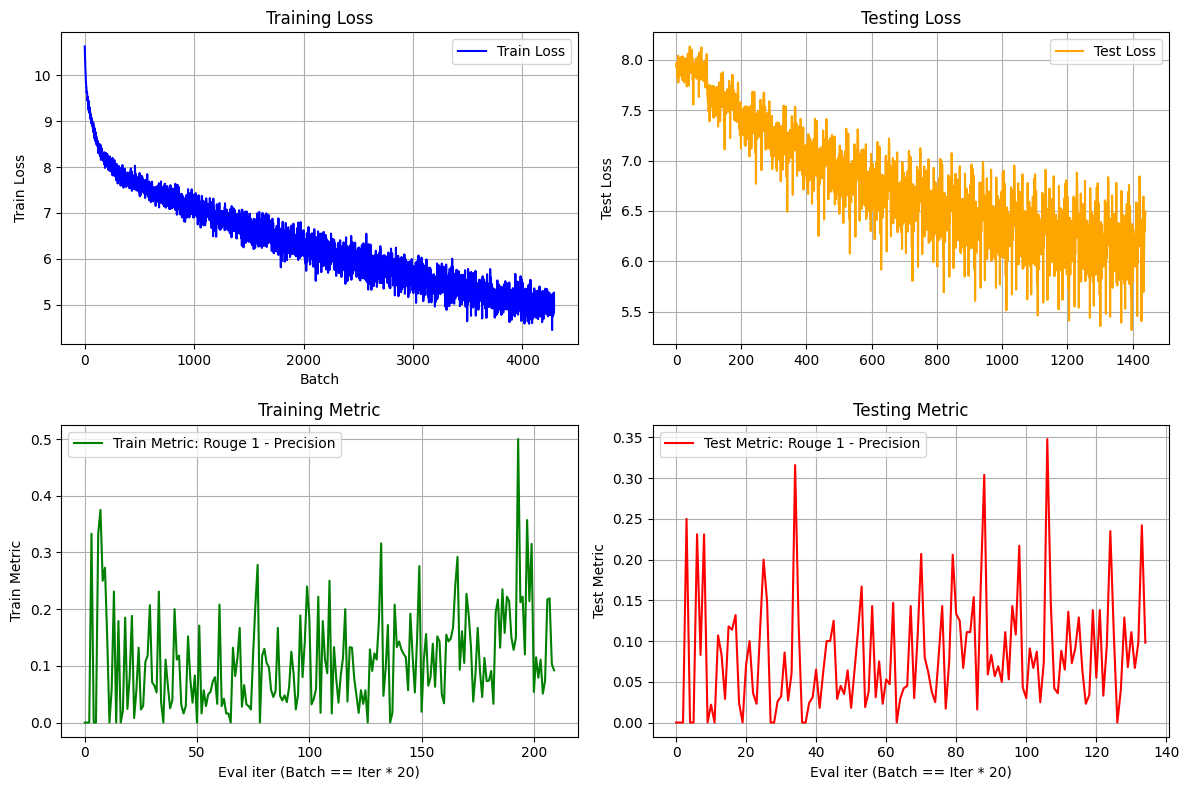

---
Metrics train


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
205,0.074,0.065,0.074,0.069,0.065,0.069,0.123186,0.123186,0.612612,0.591095,0.601661
206,0.217,0.122,0.217,0.156,0.122,0.156,0.083129,0.041565,0.709300,0.636838,0.671119
207,0.219,0.152,0.219,0.179,0.152,0.179,0.242118,0.242118,0.626619,0.591737,0.608679
208,0.103,0.111,0.103,0.107,0.111,0.107,0.230769,0.124035,0.658338,0.613180,0.634957
209,0.092,0.158,0.092,0.116,0.158,0.116,0.185185,0.185185,0.601423,0.616009,0.608628


---
Metrics test


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
130,0.111,0.100,0.111,0.105,0.100,0.105,0.094194,0.094194,0.629652,0.602682,0.615872
131,0.067,0.051,0.067,0.058,0.051,0.058,0.134694,0.134694,0.632584,0.560796,0.594531
132,0.098,0.105,0.098,0.101,0.105,0.101,0.250000,0.250000,0.584586,0.588096,0.586336
133,0.242,0.129,0.242,0.168,0.129,0.168,0.166114,0.166114,0.693707,0.602542,0.644919
134,0.098,0.093,0.098,0.095,0.093,0.095,0.190478,0.190478,0.595107,0.584524,0.589768


In [ ]:
import torch.optim as optim

# Инициализация модели
model = BertSummarizer(
    bert_model_name=model_name,
    hidden_size=768,
    num_decoder_layers=3,
    num_heads=8,
    dropout=0.1,
    tokenizer=tokenizer
).to(device)

# Настройка оптимизатора и функции потерь
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Запуск обучения
num_epochs = 15
trained_model = train_model(model, num_epochs, train_dataloader, eval_dataloader, optimizer, criterion)


In [ ]:
# Инициализация модели и загрузка модели
uploaded_model = BertSummarizer(
    bert_model_name=model_name,
    hidden_size=768,
    num_decoder_layers=3,
    num_heads=8,
    dropout=0.1,
    tokenizer=tokenizer
)

uploaded_model.load_state_dict(
    torch.load('/content/drive/MyDrive/Colab Notebooks/models/seq2seq_classic_model.pth',
               map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    )

uploaded_model = uploaded_model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data4test['text']

'После более чем 12-часовых консультаций Совет Безопасности ООН согласовал заявление председателя по израильскому штурму «Флотилии свободы». Совбез осудил захват флотилии, требует немедленно отпустить суда и призывает к проведению международного расследования инцидента, сообщает BBC со ссылкой на дипломатические источники. Экстренное заседание СБ ООН было созвано по инициативе Турции и Ливана после того, как израильские военные перехватили шесть судов шедшего в Газу гуманитарного конвоя. Согласно сообщению минобороны Израиля, при захвате погибли девять человек, ранены еще 33 человека. По информации посольства Израиля в Москве, в операции пострадали 10 израильских военных. В ходе открытого обсуждения Турция выступила с резкой критикой действий Израиля. «Попросту говоря, это равносильно бандитизму и пиратству. Это убийство, осуществленное руками государства», — заявил в ходе заседания турецкий министр иностранных дел Ахмет Давутоглу. «Эта флотилия была чем угодно, только не гуманитарной 

In [ ]:
data4test['summary']

'Совбез ООН собрался на экстренное совещание для обсуждения захвата «Флотилии свободы» Израилем. Дипломаты в течение 12 часов согласовывали позицию. Их резолюция осуждает захват гуманитарных судов и призывает к международному расследованию. Тем временем израильские власти готовятся депортировать полсотни пассажиров с захваченных кораблей.'

In [ ]:
# Токенизация текста
inputs = trained_model.tokenizer.encode_plus(
    data4test['text'],
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512  # максимальная длина текста, на котором модель обучалась
)

input_ids = inputs['input_ids'].to(trained_model.device)  # Токенизированные входные данные
attention_mask = inputs['attention_mask'].to(trained_model.device)  # Маска внимания

# Суммаризация
summary_text = trained_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
summary_text = summary_text.replace(' ##', '')

print("Суммаризация текста:")
print(summary_text)

Суммаризация текста:
россия и к выводу в сша. власти сша не только о том числе и не только к такому выводу. ранее к такому выводу, что их их их их их их их их их их их их их их их их их.


In [ ]:
# Токенизация текста
orig_text = 'В Москве часто проходят игры по футболу, потому что в Москве много команд: Спартак, ЦСКА, Динамо, Локомотив, Торпедо'

inputs = model.tokenizer.encode_plus(
    orig_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
)

input_ids = inputs['input_ids'].to(model.device)  # Токенизированные входные данные
attention_mask = inputs['attention_mask'].to(model.device)  # Маска внимания

# Суммаризация
summary_text = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
summary_text = summary_text.replace(' ##', '')

print("Суммаризация текста:")
print(summary_text)

Суммаризация текста:
в москве и россии будет зависеть от поражения от поражения от « спартак » и « спартак » — санкт - петербурге. в москве и россии и россии по футболу 2018 года.


## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

<!--  -->

В коассе BertSummarizer_many_generation_type реализовал стратегии по выборе токена 'Top-k' и 'Nucleus_Sampling', для Beam Search создал отдельный класс BertSummarizer_beam_search

<!--  -->

По моим ощущениям (в том числе от процесса обучения, где я выврдил промежуточные примеры суммаризации) - лучше всего обучилась модель с стратегией top-k, учитая что она обучалась на меньшем кол-ве объектах и эпох в сравнении с первой версией модели.

К можалению не успел попробовать разные стартегии подбора learning rate и другие разновидности оптимайзера.

Во время обучения наблюдал, как модель стартовала с "Или или или", переходила в этап "Или в или в или в" и в конце обучения уже могла выдавать пару связных слов, даже в тему исходного текста. Но все же не одна модель не обучена до желаемого состояния

Nucleus Sampling показала очень плохое качество, скорее всего из за того, что я задал порог для кумулятивной вероятнсти = 0.85, который видел в одном из примеров. Подозреваю, что у меня не было токенов с высокой вероятностью и для выбора попадали сотни рандомных токенов.

<!--  -->

___Top-k и Nucleus_Sampling___

In [24]:
class BertSummarizer_many_generation_type(nn.Module):
    def __init__(
        self,
        bert_model_name='deepvk/bert-base-uncased',
        hidden_size=768,
        num_decoder_layers=3,
        num_heads=8,
        dropout=0.1,
        tokenizer=None,
        type_generation='Classic',
        top_token_for_type_generation=0
        ): # 'bert-base-uncased'
        '''
        Инициализация модели

        :bert_model_name: Название предобученной модели BERT.
        :hidden_size: Размер скрытого слоя.
        :num_decoder_layers: Количество слоев декодера.
        :num_heads: Количество голов в многоголовом внимании.
        :dropout: Коэффициент дропаута.
        :tokenizer: Токенизатор для обработки специальных токенов.
        :type_generation: - Стратегия выбора для генерации следующего токена, доступные значения: 'Classic', 'Top-k', 'Nucleus_Sampling'
        :top_token_for_type_generation: - для type_generation='Classic' не учавствует, для type_generation='Top-k' - целое число (кол-во токенов)
          для type_generation='Top-k' - float, такй что  top_token_for_type_generation > 0 & <= 1 (сумма вероятностей токена)
        '''
        super(BertSummarizer_many_generation_type, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.tokenizer = tokenizer
        self.type_generation = type_generation
        self.top_token_for_type_generation = top_token_for_type_generation

        # Проверка на валидность type_generation
        if type_generation == 'Top-k':
            assert type(top_token_for_type_generation) == int and top_token_for_type_generation > 0
        elif type_generation == 'Nucleus_Sampling':
            assert top_token_for_type_generation <= 1.0 and top_token_for_type_generation > 0.0
        else:
          pass

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size) # (vocab_size, hidden_size)

        # Один слой декодера
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
            )

        # Инициаизация декодера
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
            )

        # Последний слой для преобразования выхода декодера обратно в токены
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size) # (hidden_size, vocab_size)

    def generate_square_subsequent_mask(self, T):
        '''
        Функция для создания маски для предотвращения заглядывания вперед в декодере

        :T: Длина последовательности декодера.

        return: Квадратная маска, где элементы выше диагонали заполнены -inf
        '''
        mask = torch.triu(torch.ones(T, T), diagonal=1).float()
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask.to(self.device)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        '''
        Прямой проход

        :input_ids: Входные токены
        :attention_mask: Маска внимания для входных токенов
        :decoder_input_ids: Токены для декодера

        return: Логиты
        '''
        # Выходы кодировщика BERT сохраним в memory
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # (batch_size, src_seq_len, hidden_size)
        memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

        # Эмбеддинги для декодера
        embedded = self.embedding(decoder_input_ids).transpose(0, 1)  # (tgt_seq_len, batch_size, hidden_size)

        # Длина последовательности декодера
        tgt_seq_len = embedded.size(0) # (tgt_seq_len)
        # Генерация маски для последовательности декодера
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)  # (tgt_seq_len, tgt_seq_len)


        # Создание маски паддинга для декодера
        if self.tokenizer and self.tokenizer.pad_token_id is not None:
            tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)  # (batch_size, tgt_seq_len)
        else:
            tgt_key_padding_mask = None

        # Передача в декодер
        output = self.decoder(
            tgt=embedded,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        ) # (tgt_seq_len, batch_size, hidden_size)

        # Приводим выход в пространство словаря
        output = self.fc_out(output).transpose(0, 1)  # (batch_size, tgt_seq_len, vocab_size)

        return output  # Возвращаем сырые логиты

    def generate(self, input_ids, attention_mask, max_len=128, type_generation='Classic'):
        '''
        Генерация последовательности

        :input_ids: Идентификаторы входных токенов (размерность: [batch_size, src_seq_len]).
        :attention_mask: Маска внимания для входных токенов (размерность: [batch_size, src_seq_len]).
        :max_len: Максимальная длина генерируемой последовательности.

        return: cгенерированная последовательность
        '''
        self.eval()
        with torch.no_grad():
            # Получим последнее скрытое состояние BERT
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

            batch_size = input_ids.size(0)

            # Начинаем с токена [CLS]
            decoder_input_ids = torch.full(
                (batch_size, 1),
                self.tokenizer.cls_token_id,  # Используем self.tokenizer
                dtype=torch.long
            ).to(self.device) # (batch_size, 1)

            generated_tokens = []

            for _ in range(max_len):
                # Получение эмбеддингов для текущих токенов декодера
                embedded = self.embedding(decoder_input_ids).transpose(0, 1)  # (tgt_seq_len, batch_size, hidden_size)
                # Текущая длина последовательности декодера
                tgt_seq_len = embedded.size(0)
                # Генерация маски для последовательности декодера
                tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)  # tgt_mask: (tgt_seq_len, tgt_seq_len)

                # Создание маски паддинга для декодера, если используется
                if self.tokenizer.pad_token_id is not None:
                    tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)  # (batch_size, tgt_seq_len)
                else:
                    tgt_key_padding_mask = None

                # Передача в декодер
                decoder_output = self.decoder(
                    tgt=embedded,
                    memory=memory,
                    tgt_mask=tgt_mask,
                    tgt_key_padding_mask=tgt_key_padding_mask
                )  # (tgt_seq_len, batch_size, hidden_size)

                # Приводим выход в пространство словаря
                output = self.fc_out(decoder_output).transpose(0, 1)  # (batch_size, tgt_seq_len, vocab_size)

                # Получение логитов для следующего токена
                next_token_logits = output[:, -1, :]  # (batch_size, vocab_size)

                '''
                Ниже реализованны разные варианты выбора следующего токена.
                Представлен как класический подход - выьор самого вероятного токена.
                Так и модифицировнные:
                  * Top-k, где случайно выбираем токен из K самых вероятных
                  * Nucleus Sampling, где случайно выбираем токенов из токенов, сумма вероятностей которых равна K
                 '''
                if self.type_generation == 'Classic':
                    # Получение индекса токена с наибольшей вероятностью
                    next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)  # (batch_size, 1)

                elif self.type_generation == 'Top-k':
                  # Получаем топ-k токенов, логиты, вероятности
                  top_k_logits, top_k_indices = torch.topk(
                      next_token_logits, self.top_token_for_type_generation, dim=-1)
                  top_k_probs = torch.nn.functional.softmax(top_k_logits, dim=-1)
                  # Выбираем токен и преобразуем обратно
                  next_token_id = torch.multinomial(top_k_probs, num_samples=1)
                  next_token_id = top_k_indices.gather(1, next_token_id)

                elif self.type_generation == 'Nucleus_Sampling':
                  # Получим вероятности и отсортируем их по убыванию
                  next_token_probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                  sorted_probs, sorted_indices = torch.sort(next_token_probs, descending=True, dim=-1)
                  # Кумулятивную суммуа вероятностей
                  cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                  # Выбираем только те токены, у которых суммарная вероятность <= top_p
                  drop_indices = cumulative_probs > self.top_token_for_type_generation
                  # Сдвигаем маску, чтобы сохранить первый токен, который превышает порог
                  drop_indices[..., 1:] = drop_indices[..., :-1].clone()
                  drop_indices[..., 0] = False
                  # Обнуляем вероятности для отобранных индексов
                  sorted_probs[drop_indices] = 0.0
                  # Нормализуем вероятности оставшихся токенов, выбираем из них токен случайным образом
                  sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
                  next_token_id = torch.multinomial(sorted_probs, num_samples=1)
                else:
                  # Проверка на совместимость введеного типа генерации
                  raise ValueError(f"type_generation need be in ('Classic', 'Top-k', 'Nucleus_Sampling'), but current type_generation={type_generation}")

                # Добавляем выбранный токен к декодеру
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

                # Созраняем токен
                generated_tokens.append(next_token_id)

                # Проверяем, не достигнут ли конец последовательности
                if (next_token_id == self.tokenizer.sep_token_id):
                    break

            # Преобразуем токены в строки
            generated_sequences = [self.tokenizer.decode(seq, skip_special_tokens=True) for seq in decoder_input_ids]

            return generated_sequences[0]


___TOP K___

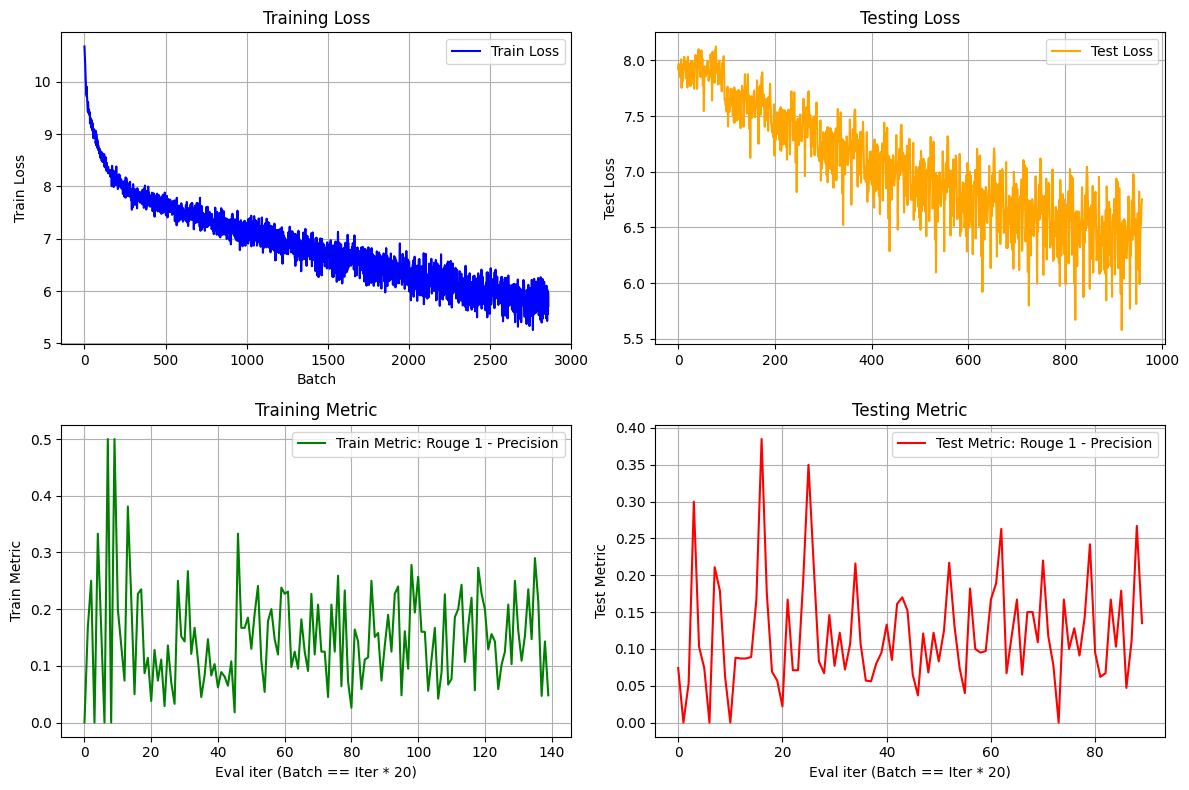

---
Metrics train


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
135,0.290,0.180,0.290,0.222,0.180,0.222,0.211999,0.211999,0.629757,0.574145,0.600666
136,0.213,0.286,0.213,0.244,0.286,0.244,0.294118,0.083683,0.655673,0.660449,0.658052
137,0.047,0.148,0.047,0.071,0.148,0.071,0.095238,0.095238,0.612827,0.607004,0.609901
138,0.143,0.156,0.143,0.149,0.156,0.149,0.148148,0.148148,0.668801,0.623903,0.645573
139,0.048,0.043,0.048,0.045,0.043,0.045,0.067345,0.067345,0.642524,0.591560,0.615989


---
Metrics test


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
85,0.179,0.233,0.179,0.202,0.233,0.202,0.230769,0.078975,0.624541,0.599377,0.611700
86,0.047,0.051,0.047,0.049,0.051,0.049,0.090909,0.090909,0.646444,0.594968,0.619639
87,0.111,0.079,0.111,0.092,0.079,0.092,0.090733,0.090733,0.626856,0.610729,0.618687
88,0.267,0.129,0.267,0.174,0.129,0.174,0.108680,0.108680,0.670608,0.608837,0.638232
89,0.135,0.116,0.135,0.125,0.116,0.125,0.157464,0.157464,0.624684,0.589168,0.606407


In [ ]:
# Инициализация модели
model_topk = BertSummarizer_many_generation_type(
    bert_model_name=model_name,
    hidden_size=768,
    num_decoder_layers=3,
    num_heads=8,
    dropout=0.1,
    tokenizer=tokenizer,
    type_generation='Top-k',
    top_token_for_type_generation=8
).to(device)

# Настройка оптимизатора и функции потерь
optimizer = optim.AdamW(model_topk.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Запуск обучения
num_epochs = 10
trained_model = train_model(model_topk, num_epochs, train_dataloader, eval_dataloader, optimizer, criterion)

In [ ]:
# Пример генерации модели top k
orig_text = 'В москве прошел финал КХЛ и Спартак выиграл у Динамо'

# Токенизация текста
inputs = trained_model.tokenizer.encode_plus(
    orig_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
)

input_ids = inputs['input_ids'].to(trained_model.device)  # Токенизированные входные данные
attention_mask = inputs['attention_mask'].to(trained_model.device)  # Маска внимания

# Суммаризация
summary = trained_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
summary = summary.replace(' ##', '')

print("Суммаризация текста:")
print(summary)

Суммаризация текста:
в субботу по словам, и кхл в москве и в москве, а его « спартаку » — 1 : 3 : - за то « рос », не может не сумелк.


___Nucleus_Sampling___

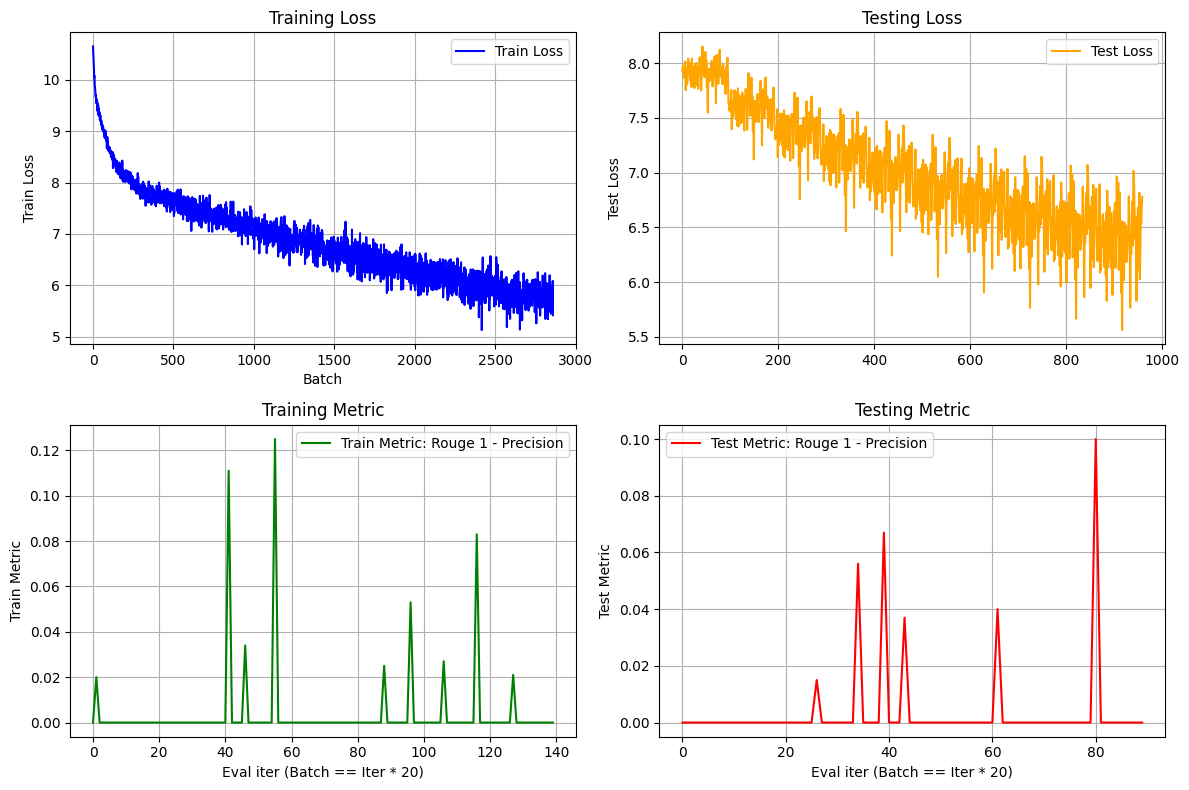

---
Metrics train


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
135,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.558416,0.476283,0.514090
136,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.561184,0.523795,0.541845
137,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.550292,0.541662,0.545943
138,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.542646,0.536861,0.539738
139,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.556635,0.581454,0.568774


---
Metrics test


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
85,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.548498,0.546652,0.547574
86,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.528426,0.541004,0.534641
87,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.549094,0.491706,0.518818
88,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.516199,0.482563,0.498815
89,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.532729,0.542740,0.537688


In [25]:
# Инициализация модели
model_topk = BertSummarizer_many_generation_type(
    bert_model_name=model_name,
    hidden_size=768,
    num_decoder_layers=3,
    num_heads=8,
    dropout=0.1,
    tokenizer=tokenizer,
    type_generation='Nucleus_Sampling',
    top_token_for_type_generation=0.85
).to(device)

# Настройка оптимизатора и функции потерь
optimizer = optim.AdamW(model_topk.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Запуск обучения
num_epochs = 10
nucleus_sampling_model = train_model(model_topk, num_epochs, train_dataloader, eval_dataloader, optimizer, criterion)

In [33]:
# Пример генерации nucleus_sampling_model

orig_text = 'В москве прошел финал КХЛ и Спартак выиграл у Динамо'
# Токенизация текста
inputs = nucleus_sampling_model.tokenizer.encode_plus(
    orig_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
)

input_ids = inputs['input_ids'].to(nucleus_sampling_model.device)  # Токенизированные входные данные
attention_mask = inputs['attention_mask'].to(nucleus_sampling_model.device)  # Маска внимания

# Суммаризация
summary = nucleus_sampling_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
summary = summary.replace(' ##', '')

print("Суммаризация текста:")
print(summary)

Суммаризация текста:
░ υ тержет контро 🌟зация ▶ ник ❄ точки приму w72 зрениякту рез стала 💎 m' ф ​ ру гуля симую зна комплек ❗ского иг🤗бap اфици 🇷 htm 😻нокаться


__Beam Search__

In [ ]:
class BertSummarizer_beam_search(nn.Module):
    def __init__(
        self,
        bert_model_name='deepvk/bert-base-uncased',
        hidden_size=768,
        num_decoder_layers=3,
        num_heads=8,
        dropout=0.1,
        tokenizer=None,
        ):
        """
        Инициализация модели

        :bert_model_name: Название предобученной модели BERT.
        :hidden_size: Размер скрытого слоя.
        :num_decoder_layers: Количество слоев декодера.
        :num_heads: Количество голов в многоголовом внимании.
        :dropout: Коэффициент дропаута.
        :tokenizer: Токенизатор для обработки специальных токенов.
        """
        super(BertSummarizer_beam_search, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.tokenizer = tokenizer

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size) # (vocab_size, hidden_size)

        # Один слой декодера
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout
            )

        # Инициаизация декодера
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers
            )

        # Последний слой для преобразования выхода декодера обратно в токены
        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size) # (hidden_size, vocab_size)

    def generate_square_subsequent_mask(self, T):
        """
        Функция для создания маски для предотвращения заглядывания вперед в декодере

        :T: Длина последовательности декодера.

        return: Квадратная маска, где элементы выше диагонали заполнены -inf
        """
        mask = torch.triu(torch.ones(T, T), diagonal=1).float()
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask.to(self.device)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        """
        Прямой проход

        :input_ids: Входные токены
        :attention_mask: Маска внимания для входных токенов
        :decoder_input_ids: Токены для декодера

        return: Логиты
        """
        # Выходы кодировщика BERT сохраним в memory
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # (batch_size, src_seq_len, hidden_size)
        memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

        # Эмбеддинги для декодера
        embedded = self.embedding(decoder_input_ids).transpose(0, 1)  # (tgt_seq_len, batch_size, hidden_size)

        # Длина последовательности декодера
        tgt_seq_len = embedded.size(0) # (tgt_seq_len)
        # Генерация маски для последовательности декодера
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)  # (tgt_seq_len, tgt_seq_len)


        # Создание маски паддинга для декодера
        if self.tokenizer and self.tokenizer.pad_token_id is not None:
            tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)  # (batch_size, tgt_seq_len)
        else:
            tgt_key_padding_mask = None

        # Передача в декодер
        output = self.decoder(
            tgt=embedded,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        ) # (tgt_seq_len, batch_size, hidden_size)

        # Приводим выход в пространство словаря
        output = self.fc_out(output).transpose(0, 1)  # (batch_size, tgt_seq_len, vocab_size)

        return output  # Возвращаем сырые логиты

    def generate(self, input_ids, attention_mask, max_len=128, beam_size=3):
        """
        Генерация последовательности с использованием Beam Search.

        :input_ids: Идентификаторы входных токенов (размерность: [batch_size, src_seq_len]).
        :attention_mask: Маска внимания для входных токенов (размерность: [batch_size, src_seq_len]).
        :max_len: Максимальная длина генерируемой последовательности.
        :beam_size: Размер луча (количество рассматриваемых кандидатов на каждом шаге).

        return: Сгенерированная последовательность
        """
        self.eval()
        with torch.no_grad():
            # Получим последнее скрытое состояние BERT
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state.transpose(0, 1)  # (src_seq_len, batch_size, hidden_size)

            batch_size = input_ids.size(0)

            decoder_input_ids = torch.full(
                (batch_size, 1),
                self.tokenizer.pad_token_id,
                dtype=torch.long
                ).to(self.device)

            # Инициализация лучей Beam Search
            beams = [(decoder_input_ids, 0.0)]

            for _ in range(max_len):
                new_beams = []  # Новый список лучей

                for decoder_input_ids, beam_score in beams:

                    # эмбеддини текущих токенов (декодер)
                    embedded = self.embedding(decoder_input_ids).transpose(0, 1)
                    tgt_seq_len = embedded.size(0)
                    tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)

                    # Создание маски паддинга для декодера, если используется
                    if self.tokenizer.pad_token_id is not None:
                        tgt_key_padding_mask = (decoder_input_ids == self.tokenizer.pad_token_id)
                    else:
                        tgt_key_padding_mask = None

                    # Передача в декодер
                    decoder_output = self.decoder(
                        tgt=embedded,
                        memory=memory,
                        tgt_mask=tgt_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask
                    )

                    # Приводим выход в пространство словаря
                    output = self.fc_out(decoder_output).transpose(0, 1)

                    # top-k токенов отсортированных по лог-вероятностей
                    next_token_logits = output[:, -1, :]
                    next_token_log_probs = torch.log_softmax(next_token_logits, dim=-1)
                    top_k_log_probs, top_k_ids = torch.topk(next_token_log_probs, beam_size, dim=-1)

                    # Для каждого кандидата находим дальнейшую последовательность
                    for i in range(beam_size):
                        new_decoder_input_ids = torch.cat([decoder_input_ids, top_k_ids[:, i].unsqueeze(-1)], dim=-1)
                        new_beam_score = beam_score + top_k_log_probs[0, i].item()  # Суммарная вероятность
                        new_beams.append((new_decoder_input_ids, new_beam_score))

                # Оставим только лучшею последовательность
                new_beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]
                beams = new_beams

                # Остановимся, если достигли конца последовательности
                if any((beam[0][0, -1] == self.tokenizer.pad_token_id).item() for beam in beams):
                    break

            # Лучший из оставшихся лучей
            best_beam = beams[0][0]

            # Токены в строку
            generated_sequence = self.tokenizer.decode(best_beam[0], skip_special_tokens=True)

            return generated_sequence


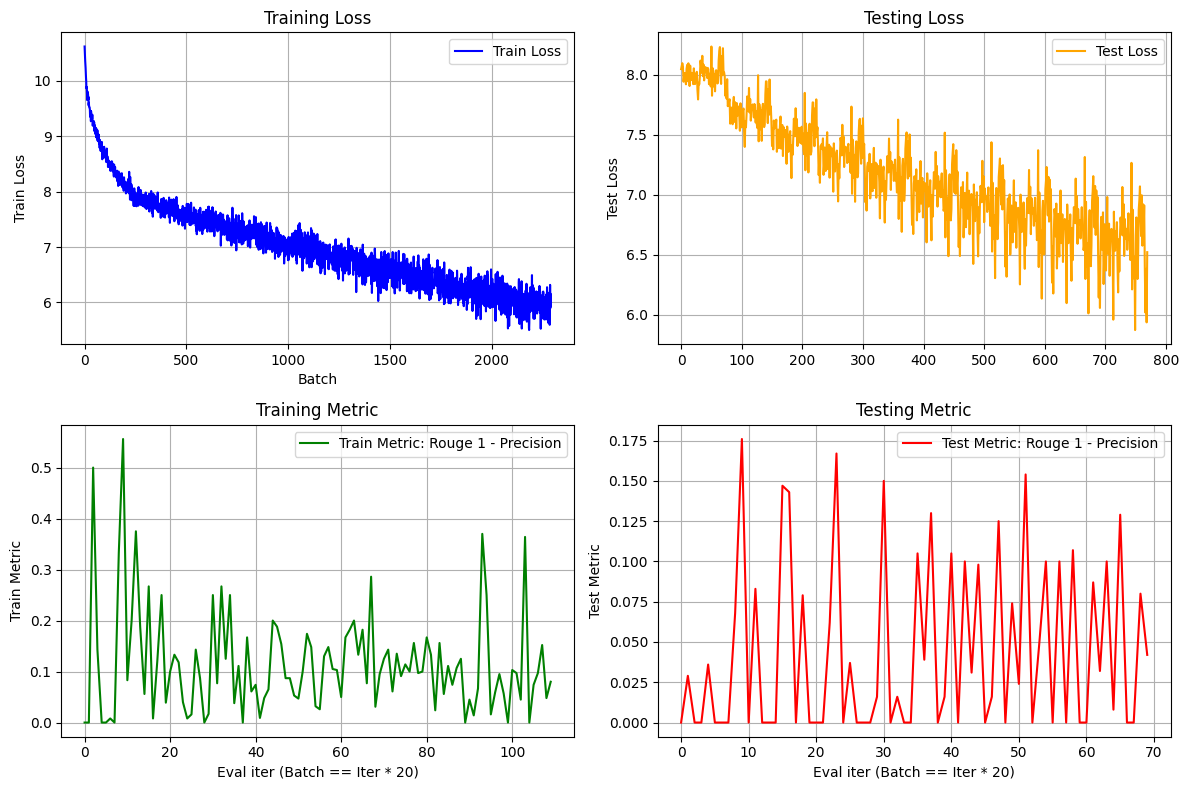

---
Metrics train


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
105,0.074,0.133,0.074,0.095,0.133,0.095,0.214286,0.079388,0.540498,0.570810,0.555241
106,0.097,0.073,0.097,0.083,0.073,0.083,0.144856,0.144856,0.587111,0.565416,0.576059
107,0.152,0.159,0.152,0.155,0.159,0.155,0.400000,0.400000,0.531754,0.514839,0.523160
108,0.048,0.088,0.048,0.062,0.088,0.062,0.157895,0.157895,0.545761,0.596328,0.569925
109,0.080,0.054,0.080,0.064,0.054,0.064,0.112506,0.112506,0.545105,0.519966,0.532239


---
Metrics test


,ROUGE_1_PRECISION,ROUGE_1_recall,ROUGE_1_F1,ROUGE_2_PRECISION,ROUGE_2_recall,ROUGE_2_F1,BLEU_1,BLEU_2,BERT_SCORE_PRECISION,BERT_SCORE_RECALL,BERT_SCORE_F1
65,0.129,0.095,0.129,0.109,0.095,0.109,0.200368,0.200368,0.559964,0.535782,0.547606
66,0.000,0.000,0.000,0,0.000,0,0.000000,0.000000,0.582830,0.570105,0.576397
67,0.000,0.000,0.000,0,0.000,0,0.000000,0.000000,0.460740,0.522396,0.489635
68,0.080,0.077,0.080,0.078,0.077,0.078,0.128105,0.128105,0.588905,0.572637,0.580657
69,0.042,0.038,0.042,0.04,0.038,0.04,0.070773,0.070773,0.553146,0.543599,0.548331


In [ ]:
# Инициализация модели
beam_screach_model = BertSummarizer_beam_search(
    bert_model_name=model_name,
    hidden_size=768,
    num_decoder_layers=3,
    num_heads=8,
    dropout=0.1,
    tokenizer=tokenizer,
).to(device)

# Настройка оптимизатора и функции потерь
optimizer = optim.AdamW(beam_screach_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Запуск обучения
num_epochs = 10
beam_screach_model = train_model(beam_screach_model, num_epochs, train_dataloader, eval_dataloader, optimizer, criterion)

In [ ]:
# Пример генерации beam_screach_model
orig_text = 'В москве прошел финал КХЛ и Спартак выиграл у Динамо'
# Токенизация текста
inputs = beam_screach_model.tokenizer.encode_plus(
    orig_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=512
)

input_ids = inputs['input_ids'].to(beam_screach_model.device)  # Токенизированные входные данные
attention_mask = inputs['attention_mask'].to(beam_screach_model.device)  # Маска внимания

# Суммаризация
summary = beam_screach_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_len=128)
summary = summary.replace(' ##', '')

print("Суммаризация текста:")
print(summary)

Суммаризация текста:
сборная россии по волеиболу « динамо » и « зенита » в первом матче против « зенита » ( 3 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4 : 1 / 4, а также в москве.


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*